## Réalisation de mon propre réseau CNN

**CNN** : Convolutional Neural Networks : réseau de neurones convolutif

Un **réseau de neurones** est un modèle d'intelligence artificielle constitué de couches de neurones artificiels, transformant les entrées en sorties via des connexions pondérées et des activations non linéaires. Il peut apprendre diverses tâches en ajustant les poids de ses connexions grâce à des algorithmes d'apprentissage supervisé ou non supervisé.

Les réseaux de neurones convolutifs désignent une sous-catégorie de réseaux de neurones.
Les CNN sont spécialement conçus pour traiter des images en entrée. Leur architecture est alors plus spécifique : elle est composée de deux blocs principaux : 

**Bloc de Convolution et de Pooling**:
 - **Convolution** : Ce bloc comprend des couches de convolution qui utilisent des filtres pour détecter des caractéristiques locales telles que les bords, les textures et les motifs. Les filtres glissent sur l'image d'entrée pour créer des cartes de caractéristiques.
 - **Pooling** : Après la convolution, des couches de pooling (comme le max-pooling ou l'average pooling) sont utilisées pour réduire la dimensionnalité des cartes de caractéristiques tout en conservant les informations importantes. Cela aide à diminuer le nombre de paramètres et à éviter le surapprentissage.

**Bloc de Classification**:
 - **Couches Denses** (Fully Connected Layers): Les cartes de caractéristiques réduites et aplaties sont ensuite passées à travers des couches denses (ou fully connected) pour effectuer la classification finale. Ces couches utilisent des neurones classiques pour transformer les caractéristiques extraites en probabilités de classes.



Ensemble, ces blocs permettent aux CNN de traiter efficacement les images et de réaliser des tâches telles que la reconnaissance d'objets, la classification d'images et la détection de caractéristiques.

Import des librairies

In [106]:
import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## 1. Préparation des données

Tout d'abord, téléchargeons dossier qui contient les 4 races choisis précédemment

In [75]:
dogImages_folder = 'data/SpecificRaces'

In [76]:
# Récupérer les noms des sous-dossiers (sous-dossier =  une race)
dogList = os.listdir(dogImages_folder)

In [77]:
dogList

['Saint_Bernard', 'Chihuahua', 'Saluki', 'German_shepherd']

In [78]:
def get_folder_image_counts(path):
    """
    Obtenir les noms des dossiers dans path et le nombre d'images dans chaque dossier.

    Parameters:
    - path: Chemin vers le dossier contenant les sous-dossiers des races.

    Returns:
    - DataFrame: DataFrame contenant les noms des races et le nombre d'images.
    """
    if not os.path.exists(path):
        print(f"Path not found: {path}")
        return pd.DataFrame(columns=['Race', 'Nombre d\'images'])
    
    data = []
    
    races = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    
    for race in races:
        race_path = os.path.join(path, race)
        images = [f for f in os.listdir(race_path) if os.path.isfile(os.path.join(race_path, f))]
        data.append({'Race': race, 'Nombre d\'images': len(images)})
    
    df = pd.DataFrame(data)
    return df




In [79]:
df = get_folder_image_counts(dogImages_folder)


In [80]:
df

,Race,Nombre d'images
0,Saint_Bernard,340
1,Chihuahua,304
2,Saluki,400
3,German_shepherd,304


###### Affichage d'une image de chaque race de chien choisie : 

In [81]:
def show_dogImages_sample(dogImages_folder):
    fig, axes = plt.subplots(1, 4, figsize=(8, 8))

    # Itérer sur chaque sous-dossier et afficher une image aléatoire
    for ax, dogbreed in zip(axes.flatten(), dogList):
        dogbreed_folder = os.path.join(dogImages_folder, dogbreed)
        images = os.listdir(dogbreed_folder)
        if images:
            # Choisir une image aléatoire dans le sous-dossier
            img_path = os.path.join(dogbreed_folder, random.choice(images))
            img = Image.open(img_path)

            # Afficher l'image
            ax.imshow(img)
            ax.set_title({dogbreed})
            ax.axis('off') 

    # Ajuster les espaces entre les images
    plt.tight_layout()
    plt.show()

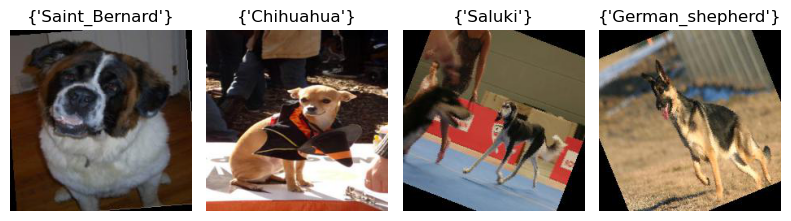

In [82]:
show_dogImages_sample(dogImages_folder)
    

In [83]:
df

,Race,Nombre d'images
0,Saint_Bernard,340
1,Chihuahua,304
2,Saluki,400
3,German_shepherd,304


In [84]:
breeds = df['Race'].tolist()

In [85]:
breeds

['Saint_Bernard', 'Chihuahua', 'Saluki', 'German_shepherd']

In [86]:
# Paramètres de chargement des données sans augmentation (puisque les images sont déjà augmentées)
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)



In [87]:
# chargement des données d'entraînement et de validation pour les 4 races choisies
train_generator = datagen.flow_from_directory(
    dogImages_folder,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=breeds
)

validation_generator = datagen.flow_from_directory(
    dogImages_folder,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes=breeds
)

Found 1080 images belonging to 4 classes.
Found 268 images belonging to 4 classes.


## 2. Définition d'un modèle CNN

Création d'un modèle CNN simple avec quelques couches de convolution et de pooling, suivi de couches denses.

In [88]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax')  # 4 classes de races de chiens
])

## 3. Compilation et entraînement initial du modèle

Compilation du modèle et entraînement sur les données d'entraînement et de validation.

In [89]:
# Compilation du modèle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [90]:
# Entraînement initial du modèle
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20  
)



Epoch 1/20
33/33 [==============================] - 8s 222ms/step - loss: 1.3923 - accuracy: 0.2996 - val_loss: 1.3612 - val_accuracy: 0.3008
Epoch 2/20
33/33 [==============================] - 7s 215ms/step - loss: 1.2761 - accuracy: 0.4065 - val_loss: 1.3334 - val_accuracy: 0.3438
Epoch 3/20
33/33 [==============================] - 7s 214ms/step - loss: 1.1592 - accuracy: 0.5143 - val_loss: 1.1931 - val_accuracy: 0.4648
Epoch 4/20
33/33 [==============================] - 7s 212ms/step - loss: 1.0014 - accuracy: 0.5954 - val_loss: 1.1355 - val_accuracy: 0.5312
Epoch 5/20
33/33 [==============================] - 7s 218ms/step - loss: 0.8117 - accuracy: 0.6765 - val_loss: 1.0901 - val_accuracy: 0.5586
Epoch 6/20
33/33 [==============================] - 7s 219ms/step - loss: 0.5928 - accuracy: 0.7739 - val_loss: 1.1469 - val_accuracy: 0.5664
Epoch 7/20
33/33 [==============================] - 8s 227ms/step - loss: 0.3987 - accuracy: 0.8731 - val_loss: 1.2228 - val_accuracy: 0.5898
Epoch 

###### Matrice de coonfusion 

In [112]:
breeds

['Saint_Bernard', 'Chihuahua', 'Saluki', 'German_shepherd']

In [114]:
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [115]:
def get_confusion_matrix(model, validation_generator, labels):
    """
    Generate and plot the confusion matrix for the given model and validation data.

    Parameters:
    - model: The trained model.
    - validation_generator: The generator providing validation data.
    - labels: List of label names corresponding to the classes.
    """
    # Get model predictions
    y_pred = model.predict(validation_generator)
    
    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true class labels
    y_true = validation_generator.classes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plot confusion matrix
    show_confusion_matrix(cm, labels)

9/9 [==============================] - 1s 57ms/step


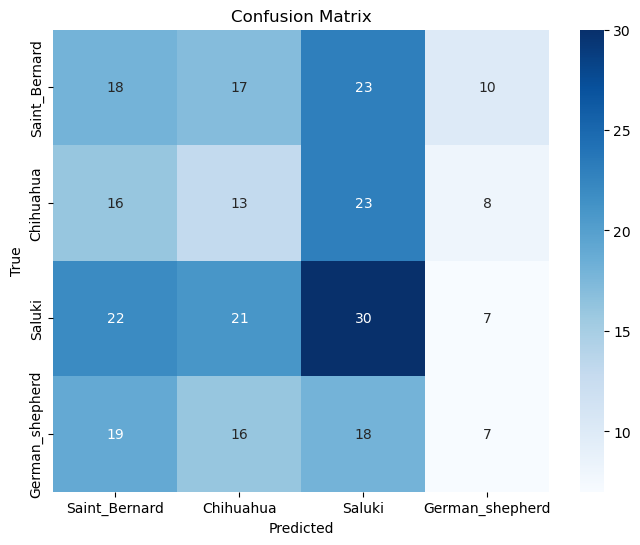

In [116]:
get_confusion_matrix(model, validation_generator, breeds)

**Analyse**

 - Saint_Bernard: Sur 68 (18+17+23+10) Saint_Bernard, 18 ont été correctement classés. Le modèle a tendance à confondre les Saint_Bernard avec les Saluki (23 erreurs).
 - Chihuahua: Sur 60 (16+13+23+8) Chihuahua, seulement 13 ont été correctement classés. Le modèle confond souvent les Chihuahua avec les Saluki (23 erreurs).
 - Saluki: Sur 80 (22+21+30+7) Saluki, 30 ont été correctement classés, ce qui est mieux que pour les autres races, mais il y a encore une confusion notable avec Saint_Bernard (22 erreurs) et Chihuahua (21 erreurs).
 - German_shepherd: Sur 60 (19+16+18+7) German_shepherd, seulement 7 ont été correctement classés. Le modèle a tendance à confondre cette race avec les autres, en particulier Saint_Bernard (19 erreurs) et Saluki (18 erreurs).

**Conclusion**

 - Le modèle a des difficultés significatives à distinguer correctement les races de chiens.
 - Saluki semble être mieux reconnu que les autres races.
 - Il y a une forte confusion entre Chihuahua et Saluki ainsi qu'entre Saint_Bernard et Saluki.
 - German_shepherd est la race la plus mal classée, avec des taux élevés de confusion avec les autres races.

## 4. Optimisation du modèle

Pour améliorer les performances, ajustement de quelques hyperparamètres : ajout des couches, changement du taux d'apprentissage, utilisation du Dropout..

In [91]:
model_optimized = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax')
])


In [92]:
# Compilation avec un taux d'apprentissage réduit
model_optimized.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [93]:
# Réentraîner le modèle optimisé
history_optimized = model_optimized.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20  # Augmenter le nombre d'époques
)

Epoch 1/20
33/33 [==============================] - 11s 304ms/step - loss: 1.5018 - accuracy: 0.3960 - val_loss: 2.8144 - val_accuracy: 0.2266
Epoch 2/20
33/33 [==============================] - 10s 293ms/step - loss: 0.8483 - accuracy: 0.6603 - val_loss: 4.5383 - val_accuracy: 0.2305
Epoch 3/20
33/33 [==============================] - 10s 309ms/step - loss: 0.5555 - accuracy: 0.7958 - val_loss: 5.7476 - val_accuracy: 0.2305
Epoch 4/20
33/33 [==============================] - 15s 466ms/step - loss: 0.3157 - accuracy: 0.9046 - val_loss: 7.3338 - val_accuracy: 0.2305
Epoch 5/20
33/33 [==============================] - 13s 382ms/step - loss: 0.1998 - accuracy: 0.9523 - val_loss: 7.3361 - val_accuracy: 0.2227
Epoch 6/20
33/33 [==============================] - 15s 461ms/step - loss: 0.1409 - accuracy: 0.9714 - val_loss: 5.9270 - val_accuracy: 0.2266
Epoch 7/20
33/33 [==============================] - 12s 370ms/step - loss: 0.0914 - accuracy: 0.9809 - val_loss: 5.1932 - val_accuracy: 0.2266

9/9 [==============================] - 1s 69ms/step


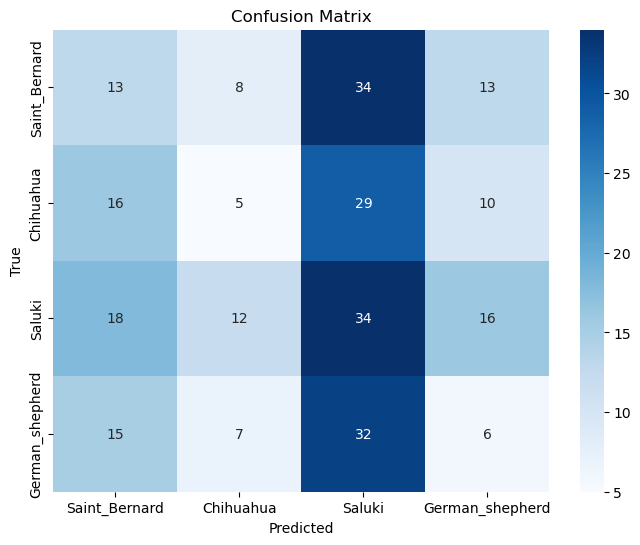

In [117]:
get_confusion_matrix(model_optimized, validation_generator, breeds)

**Analyse**

- Saint_Bernard: Sur 68 (13+8+34+13) Saint_Bernard, seulement 13 ont été correctement classés. Le modèle confond souvent les Saint_Bernard avec les Saluki (34 erreurs).
- Chihuahua: Sur 59 (16+5+28+10) Chihuahua, seulement 5 ont été correctement classés. Il y a une forte confusion avec les Saluki (28 erreurs).
- Saluki: Sur 80 (18+12+34+16) Saluki, 34 ont été correctement classés, ce qui est meilleur que pour les autres races, mais encore une confusion notable avec les autres classes.
- German_shepherd: Sur 60 (15+7+32+6) German_shepherd, seulement 6 ont été correctement classés. Le modèle confond souvent les German_shepherd avec les Saluki (32 erreurs).

**Conclusion**

- Le modèle optimisé montre toujours des difficultés significatives à distinguer correctement les races de chiens, bien que les Saluki soient mieux reconnus que les autres races.
- La confusion entre Saint_Bernard et Saluki, ainsi qu'entre Chihuahua et Saluki est toujours présente.
- German_shepherd est toujours mal classé, avec des taux élevés de confusion avec les autres races, en particulier Saluki.

## 5. Évaluation des performances

évaluation des performances du modèle optimisé sur le jeu de validation

In [94]:
# évaluation des performances du modèle initial
eval_initial = model.evaluate(validation_generator)
print(f'Model Initial - Validation Loss: {eval_initial[0]}, Validation Accuracy: {eval_initial[1]}')

9/9 [==============================] - 1s 68ms/step - loss: 2.7206 - accuracy: 0.5896
Model Initial - Validation Loss: 2.720627784729004, Validation Accuracy: 0.5895522236824036


In [95]:
# évaluation des performances du modèle optimisé
eval_optimized = model_optimized.evaluate(validation_generator)
print(f'Model Optimized - Validation Loss: {eval_optimized[0]}, Validation Accuracy: {eval_optimized[1]}')

9/9 [==============================] - 1s 78ms/step - loss: 1.4278 - accuracy: 0.5896
Model Optimized - Validation Loss: 1.4278470277786255, Validation Accuracy: 0.5895522236824036


In [101]:

# Evaluate initial model
eval_initial = model.evaluate(validation_generator)
initial_results = {'Model': 'Initial',
                   ' Accuracy': eval_initial[1],
                  ' Loss': eval_initial[0]}

# Evaluate optimized model (assuming model_optimized is defined)
eval_optimized = model_optimized.evaluate(validation_generator)
optimized_results = {'Model': 'Optimized',
                     ' Accuracy': eval_optimized[1],
                    ' Loss': eval_optimized[0]}

# Combine results into a DataFrame
results_df = pd.DataFrame([initial_results, optimized_results])



9/9 [==============================] - 1s 69ms/step - loss: 1.4278 - accuracy: 0.5896


In [102]:
results_df

,Model,Accuracy,Loss
0,Initial,0.589552,2.720628
1,Optimized,0.589552,1.427847


**Interprétation des Résultats** : 

- Les deux modèles ont une accuracy identique, ce qui signifie qu'ils prédisent correctement les mêmes pourcentages d'échantillons dans le jeu de validation.
- Cependant, le modèle optimisé présente une perte plus faible par rapport au modèle initial, ce qui suggère qu'il fait des prédictions plus précises ou qu'il est mieux adapté aux données.


##### Courbes d'Apprentissage

In [103]:
def plot_learningCurve(history): 
    # Récupérer l'historique de l'entraînement
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # Tracer la précision
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Précision entraînement')
    plt.plot(epochs, val_acc, 'r', label='Précision validation')
    plt.title('Précision entraînement et validation')
    plt.legend()

    # Tracer la perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'g', label='Perte entraînement')
    plt.plot(epochs, val_loss, 'r', label='Perte validation')
    plt.title('Perte entraînement et validation')
    plt.legend()

    plt.show()

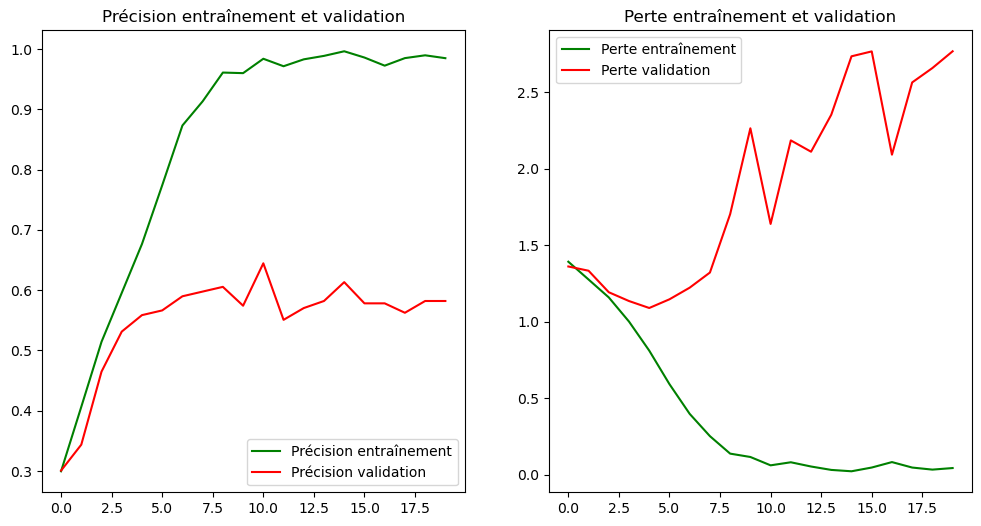

In [104]:
plot_learningCurve(history)

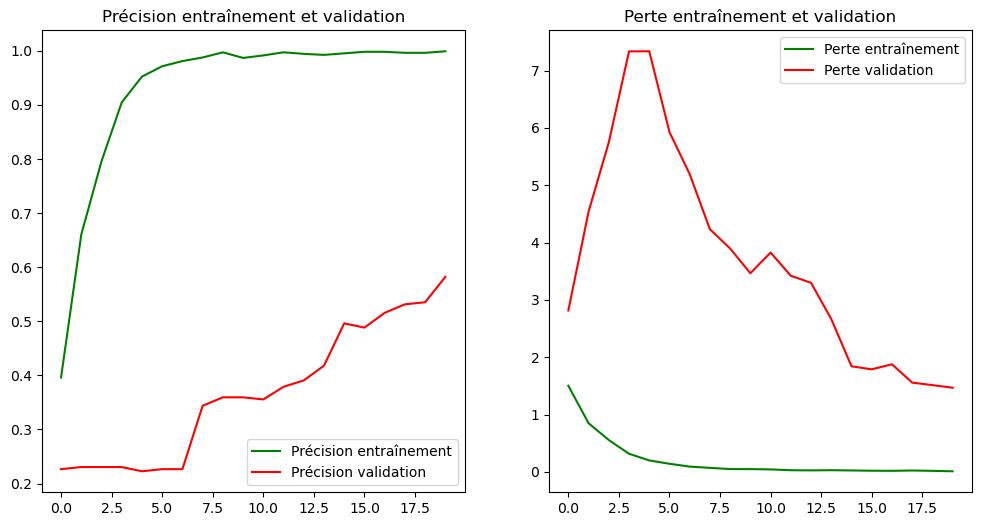

In [105]:
plot_learningCurve(history_optimized)